In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [7]:
def create_movie(image_folder, output_path, fps = 24) :

    ### INPUTS ###
    # image_folder :  [str]    Name of folder with images -- frame order is specified by image names
    # output_path  :  [str]    Path of the output movie -- must end with .mp4
    # fps          :  [int]    Movie frames per second
    ##############

    # Get the list of image files
    image_files = sorted([os.path.join(image_folder, file) for file in os.listdir(image_folder)])

    # Read the first image to get dimensions
    first_image = cv2.imread(image_files[0])
    height, width, _ = first_image.shape

    # Initialize VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Write images to video
    for image_file in image_files:
        frame = cv2.imread(image_file)
        video_writer.write(frame)

    # Release video object
    video_writer.release()

In [8]:
class Wave :
    def __init__(self, a, T, k) :
        self.a = a                  # Wave amplitude
        self.T = T                  # Wave period
        self.omega = 2 * np.pi / T  # Wave frequency
        self.k = .1                 # Wave number

class Wind :
    def __init__(self, Ux, Uy, alpha, sigma) :
        self.Ux = Ux
        self.Uy = Uy
        self.alpha = alpha
        self.sigma = sigma

In [9]:
wave = Wave(a = 2.5,
            T = 10,
            k = .1)

wind = Wind(Ux = 1, Uy = 1, alpha = 1, sigma = .1)

In [10]:
d = 15 # Volume water depth

# Create grid-coordinates
x = np.linspace(-10, 10, 15)
y = np.linspace(-10, 10, 15)
z = np.linspace(wave.a, -d, 15)

# Create the 3D meshgrid
X, Y, Z = np.meshgrid(x, y, z)

In [18]:
def water_surface_level(wave, x, t) :
    eta = wave.a * np.sin(wave.omega * t - wave.k * x)
    return eta

def velocity_field(wave, wind, t, x, z, noise = 0) :

    u_swell = wave.a * wave.omega * np.exp(wave.k * z) * np.sin(wave.omega * t - wave.k * x)
    v_swell = np.zeros_like(u_swell)
    w_swell = wave.a * wave.omega * np.exp(wave.k * z) * np.cos(wave.omega * t - wave.k * x)

    Ux_surf = np.random.normal(wind.Ux, wind.sigma, u_swell[:, :, 0].shape)
    Uy_surf = np.random.normal(wind.Uy, wind.sigma, v_swell[:, :, 0].shape)
    
    u_wind = Ux_surf * np.exp(wind.alpha * (Z / Z.max(axis = -1) - 1))
    v_wind = Uy_surf * np.exp(wind.alpha * (Z / Z.max(axis = -1) - 1))
    w_wind = np.zeros_like(u_wind)

    u, v, w = u_swell + u_wind, v_swell + v_wind, w_swell + w_wind

    u = u + np.random.normal(0, noise, u.shape)
    v = v + np.random.normal(0, noise, v.shape)
    w = w + np.random.normal(0, noise, w.shape)

    return u, v, w

In [25]:
x = X[0, 0, 0]
y = Y[0, 0, 0]
eta = water_surface_level(wave, x, 0)
eta

Ux_surf = np.random.normal(2, 0, X[:, :, 0].shape)
Uy_surf = np.random.normal(2, 0, X[:, :, 0].shape)

u_wind = Ux_surf * np.exp(wind.alpha * (Z / eta - 1))
v_wind = Uy_surf * np.exp(wind.alpha * (Z / eta - 1))

In [29]:
water = (Z <= eta).astype(np.int32)

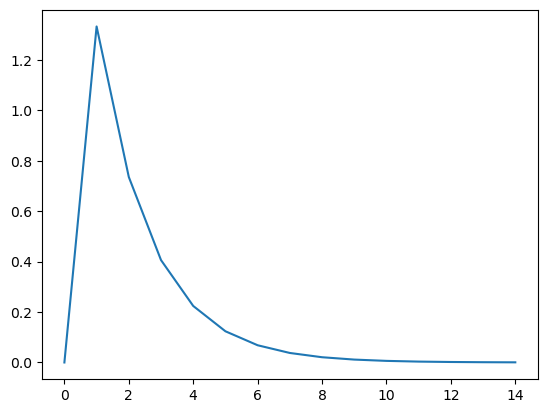

In [31]:
plt.plot(u_wind[0, 0, :] * water[0, 0, :])

In [ ]:

Ux_surf = np.random.normal(wind.Ux, wind.sigma, X[:, :, 0].shape)
Uy_surf = np.random.normal(wind.Uy, wind.sigma, X[:, :, 0].shape)

u_wind = Ux_surf * np.exp(wind.alpha * (Z / Z.max(axis = -1) - 1))
v_wind = Uy_surf * np.exp(wind.alpha * (Z / Z.max(axis = -1) - 1))

In [158]:
wave = Wave(a = 2.5,
            T = 10,
            k = .1)

wind = Wind(Ux = 0, Uy = 0, alpha = 1, sigma = 0)

x, y = 0, 0
dx, dy = 0, 0
z = water_surface_level(wave, x, 0)

horizon = 10 * wave.T
traj = []
time = np.linspace(0, horizon, 250)
for i, t in enumerate(time) :

    x += 0.5 * dx
    y += 0.5 * dy
    z = water_surface_level(wave, x, t)

    traj.append((x, y, z))
    x_traj, y_traj, z_traj = zip(*traj)

    prog = t / horizon

    eta     = water_surface_level(wave, X, t)
    u, v, w = velocity_field(wave, wind, t, X, Z, noise = 1/10)
    water = (Z <= eta).astype(np.int32)
    u, v, w = u * water, v * water, w * water

    dist = np.sqrt((X - x) ** 2 + (Y - y) ** 2 + (Z - z) ** 2)
    mask = (dist <= 2.5).astype(np.int32)
    dx = (mask * u).sum() / mask.sum()
    dy = (mask * v).sum() / mask.sum()

    plot = True
    if plot:
        # Create the quiver plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.quiver(X, Y, Z, u * (1 - mask), v * (1 - mask), w * (1 - mask), alpha = 0.5, color = 'lightblue')
        ax.quiver(X, Y, Z, u * mask, v * mask, w * mask, alpha = 0.75, color = 'darkblue')
    #   ax.quiver(0, 0, 4, 5 * wind.Ux, 5 * wind.Uy, 0, color = 'red')
        ax.plot(x_traj, y_traj, z_traj, linestyle = '--', color = 'gray')
        ax.scatter(x, y, z, color = 'red')
        ax.view_init(20, 1 + 88 * prog)
        ax.set_xlim([-11, 11])
        ax.set_ylim([-11, 11])
        ax.set_zlim([-d, 2*wave.a])
        ax.xaxis.pane.set_visible(False)
        ax.yaxis.pane.set_visible(False)
        ax.zaxis.pane.set_visible(False)
    # ax.axis('off')
        
        plt.savefig(f'anim3/step{str(i).zfill(5)}.jpg', dpi = 200)
        plt.close()

create_movie('anim3', 'anim3.mp4', fps = 12)

/var/folders/x8/gymrgfns32bd6rd_ksf19p3m0000gn/T/ipykernel_13099/3716218547.py:32: RuntimeWarning: invalid value encountered in double_scalars
  dx = (mask * u).sum() / mask.sum()
/var/folders/x8/gymrgfns32bd6rd_ksf19p3m0000gn/T/ipykernel_13099/3716218547.py:33: RuntimeWarning: invalid value encountered in double_scalars
  dy = (mask * v).sum() / mask.sum()
/var/folders/x8/gymrgfns32bd6rd_ksf19p3m0000gn/T/ipykernel_13099/3716218547.py:32: RuntimeWarning: invalid value encountered in double_scalars
  dx = (mask * u).sum() / mask.sum()
/var/folders/x8/gymrgfns32bd6rd_ksf19p3m0000gn/T/ipykernel_13099/3716218547.py:33: RuntimeWarning: invalid value encountered in double_scalars
  dy = (mask * v).sum() / mask.sum()
/var/folders/x8/gymrgfns32bd6rd_ksf19p3m0000gn/T/ipykernel_13099/3716218547.py:32: RuntimeWarning: invalid value encountered in double_scalars
  dx = (mask * u).sum() / mask.sum()
/var/folders/x8/gymrgfns32bd6rd_ksf19p3m0000gn/T/ipykernel_13099/3716218547.py:33: RuntimeWarning: i

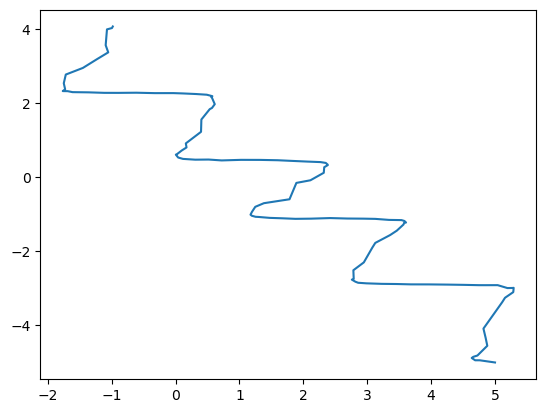

In [154]:
x_traj, y_traj, z_traj = zip(*traj)
plt.plot(x_traj, y_traj)

In [97]:
x, y = 0, 0
z = water_surface_level(wave, x, t)

dist = np.sqrt((X - x) ** 2 + (Y - y) ** 2 + (Z - z) ** 2)

In [115]:
mask = (dist <= 2.5).astype(np.int32)
dx = (mask * u).sum() / mask.sum()
dy = (mask * v).sum() / mask.sum()
dz = (mask * w).sum() / mask.sum()

In [116]:
np.array([dx, dy, dz])

array([-0.05265753, -0.00060162,  0.00577108])

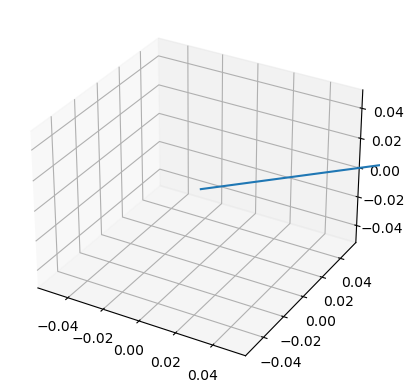

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(0, 0, 0, 1, 1, 0)

In [77]:
t = 0
eta = a * np.sin(omega * t - k * X)

In [89]:
water = (Z < eta).astype(np.int32)

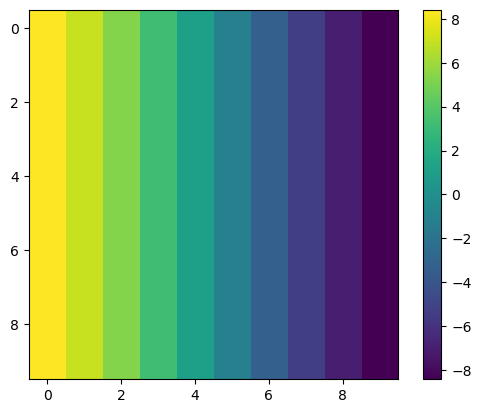

In [84]:
plt.imshow(eta[:, :, 1])
plt.colorbar()

In [95]:
water[:, :, -4]

array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]], dtype=int32)